# Step 1: Import Necessary Libraries

In [1]:
import pandas as pd
import re
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import data_preprocessing_emlakjet as dpe
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.sparse import hstack
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ensure NLTK resources are available
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/melih/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/melih/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Step 2: Load and Prepare the Data

## Load the JSON data

In [3]:

# Load the raw data
raw_data = dpe.load_json_data('istanbul_emlakjet_all_records_updated.json')

# Preprocess the data
processed_data = dpe.cleanse_and_preprocess_data(raw_data)

df = pd.DataFrame(processed_data)

# Display the first few rows of the DataFrame
df.head()


,id,categoryTypeName,tradeTypeName,estateTypeName,title,url,images,locationSummary,quickInfos,priceDetail,description,info,location,ilanda_kalis_suresi,ilan_bitis,is_active
0,16176818,konut,satılık,daire,heybeli̇ada satilik orta kat dai̇re,https://imaj.emlakjet.com/ilan/heybeliada-sati...,[https://imaj.emlakjet.com/listing/16176818/4B...,adalar - heybeliada mahallesi,Oda Sayısı: 2+1; Bulunduğu Kat: 2. Kat,"{'trendType': None, 'previousCurrency': None, ...",heybeli̇ada plaj ve klube yakin i̇ki̇ oda bi̇r...,"{'id': '16176818', 'created_at': '2024-10-29',...","{'summary': 'Adalar - Heybeliada Mahallesi', '...",5,None,True
1,16170470,konut,satılık,müstakil ev,heybeli̇ada satilik müstaki̇l bi̇na,https://imaj.emlakjet.com/ilan/heybeliada-sati...,[https://imaj.emlakjet.com/listing/16170470/09...,adalar - heybeliada mahallesi,Oda Sayısı: 3+1,"{'trendType': None, 'previousCurrency': None, ...",heybeli̇ada merkeze yakin tek katli müstaki̇l ...,"{'id': '16170470', 'created_at': '2024-10-27',...","{'summary': 'Adalar - Heybeliada Mahallesi', '...",7,None,True
2,16149397,konut,satılık,daire,büyükada lido teras sitesinde panoramik deniz ...,https://imaj.emlakjet.com/ilan/buyukada-lido-t...,[https://imaj.emlakjet.com/listing/16149397/4B...,adalar - nizam mahallesi,Oda Sayısı: 2+1; Bulunduğu Kat: 2. Kat,"{'trendType': None, 'previousCurrency': None, ...",posei̇don gayri̇menkul ve i̇nşaat ofi̇si̇\n\nt...,"{'id': '16149397', 'created_at': '2024-10-24',...","{'summary': 'Adalar - Nizam Mahallesi', 'city'...",10,None,True
3,16115980,konut,satılık,daire,tekinay'da bakımlı 4+1 köşe konumlu manzaralı ...,https://imaj.emlakjet.com/ilan/tekinay-da-baki...,[https://imaj.emlakjet.com/listing/16115980/E3...,adalar - kınalıada mahallesi,Oda Sayısı: 4+1; Bulunduğu Kat: Bahçe katı,"{'trendType': None, 'previousCurrency': None, ...",tekinay'da 4+1 köşe konumlu manzaralı ferah sa...,"{'id': '16115980', 'created_at': '2024-10-18',...","{'summary': 'Adalar - Kınalıada Mahallesi', 'c...",15,None,True
4,16112618,konut,satılık,daire,heybeli̇ada'da yatirimlik ve oturumluk eşyali ...,https://imaj.emlakjet.com/ilan/heybeliada-da-y...,[https://imaj.emlakjet.com/listing/16112618/F4...,adalar - heybeliada mahallesi,Oda Sayısı: 2+1; Bulunduğu Kat: 2. Kat,"{'trendType': None, 'previousCurrency': None, ...",yeni̇tepe gayri̇menkul 'den\n\n \n \n\nfull e...,"{'id': '16112618', 'created_at': '2024-10-18',...","{'summary': 'Adalar - Heybeliada Mahallesi', '...",16,2024-11-03,False


## Data Preparation

In [4]:
print(df.columns)

Index(['id', 'categoryTypeName', 'tradeTypeName', 'estateTypeName', 'title',
       'url', 'images', 'locationSummary', 'quickInfos', 'priceDetail',
       'description', 'info', 'location', 'ilanda_kalis_suresi', 'ilan_bitis',
       'is_active'],
      dtype='object')


In [5]:
if 'priceDetail' in df.columns:
    price_details = pd.json_normalize(df['priceDetail'])
    df = pd.concat([df.drop(['priceDetail'], axis=1), price_details], axis=1)

if 'info' in df.columns:
    info_details = pd.json_normalize(df['info'])
    df = pd.concat([df.drop(['info'], axis=1), info_details], axis=1)


In [6]:
# Extract and encode location-based features
from sklearn.preprocessing import LabelEncoder

# Extract district, locality, and town names
df['district_name'] = df['location'].apply(lambda x: x.get('district', {}).get('name', None))
df['locality_name'] = df['location'].apply(lambda x: x.get('locality', {}).get('name', None))
df['town_name'] = df['location'].apply(lambda x: x.get('town', {}).get('name', None))

# Initialize LabelEncoders
district_encoder = LabelEncoder()
locality_encoder = LabelEncoder()
town_encoder = LabelEncoder()

# Encode the location features
df['district_name_encoded'] = district_encoder.fit_transform(df['district_name'].astype(str))
df['locality_name_encoded'] = locality_encoder.fit_transform(df['locality_name'].astype(str))
df['town_name_encoded'] = town_encoder.fit_transform(df['town_name'].astype(str))

# Verify that location-based features are added
print(df[['district_name_encoded', 'locality_name_encoded', 'town_name_encoded']].head())

df['district_name_encoded'].unique()


   district_name_encoded  locality_name_encoded  town_name_encoded
0                      0                    158                274
1                      0                    158                274
2                      0                     66                425
3                      0                    204                369
4                      0                    158                274


array([ 0,  1,  2,  3,  7,  4,  5,  8,  6, 12,  9, 10, 11, 13, 33, 34, 14,
       15, 16, 17, 18, 19, 20, 22, 21, 23, 24, 25, 26, 27, 37, 28, 38, 29,
       30, 31, 35, 36, 32])

In [7]:
#LOCATION
if 'location' in df.columns:
    location_details = pd.json_normalize(df['location'])
    df = pd.concat([df.drop(['location'], axis=1), location_details], axis=1)

if 'coordinate.lat' in df.columns and 'coordinate.lon' in df.columns:
    df['lat'] = df['coordinate.lat']
    df['lon'] = df['coordinate.lon']
    df = df.drop(['coordinate.lat', 'coordinate.lon'], axis=1)

import numpy as np
from scipy.spatial import cKDTree

# Load the Excel file
park_df = pd.read_excel('istanbul-park-ve-yeil-alan-koordinatlar.xlsx')

# Step 2: Filter only park-related entries, handling NaN values
park_df = park_df[park_df['TÜR '].fillna('').str.contains('Park', case=False)]

# Step 3: Ensure latitude and longitude are numeric
park_df['LATITUDE'] = pd.to_numeric(park_df['LATITUDE'], errors='coerce')
park_df['LONGITUDE'] = pd.to_numeric(park_df['LONGITUDE'], errors='coerce')

# Step 4: Drop rows with NaN values in LATITUDE or LONGITUDE
park_df = park_df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Convert to numpy array
park_coords = park_df[['LONGITUDE', 'LATITUDE']].to_numpy()

# Step 5: Verify that all values are finite
if not np.all(np.isfinite(park_coords)):
    raise ValueError("There are still non-finite values in park coordinates.")

# Step 6: Create a KDTree for efficient nearest-neighbor search
park_tree = cKDTree(park_coords)

# Step 7: Define a function to calculate the distance to the nearest park
def find_nearest_park_distance(row):
    point = [row['lon'], row['lat']]
    distance, _ = park_tree.query(point)
    return distance

# Step 8: Apply the function to the real estate data
df['distance_to_park'] = df.apply(find_nearest_park_distance, axis=1)

# Verify the result
print(df[['lon', 'lat', 'distance_to_park']].head())


         lon        lat  distance_to_park
0  29.092574  40.879548          0.004870
1  29.096407  40.878453          0.003291
2  29.127030  40.873372          0.003516
3  29.053536  40.910136          0.053090
4  29.096951  40.876242          0.001986


In [8]:
mall_coordinates = [
    (41.11057129506558, 29.03324286718944),  # Istinye Park – Sarıyer
    (41.06268087107968, 28.807461223056364),  # Mall of Istanbul – Başakşehir
    (41.06711470503005, 29.015554896070412),  # Zorlu Center – Beşiktaş
    (40.999637820565226, 29.072885881479465), # Emaar Square Mall – Üsküdar
    (41.0786964086412, 29.010972596070914),   # Kanyon Shopping Center – Şişli
    (40.96562649212199, 28.797951696065073),  # Aqua Florya – Bakırköy
    (41.0804931294411, 28.877394451892833),   # Venezia Mega Outlet – Gaziosmanpaşa
    (41.04768078876212, 28.89691088257621),   # Forum Istanbul – Bayrampaşa
    (41.06327573080746, 28.991669082577122),  # Cevahir Mall – Şişli
    (41.021045606256955, 29.03949739606786),  # Capitol – Üsküdar
    (40.93786408646402, 29.326173282570437),  # Viaport Asia Outlet – Pendik
    (41.07639443902365, 29.013501082577847),  # Metrocity – Levent, Beşiktaş
    (40.986014245704126, 29.09975372490178),  # Palladium Mall – Ataşehir
    (40.974266074895134, 28.87005201140803),  # Galleria Mall – Bakırköy
    (40.9528418304794, 29.12186246722875),    # Hilltown AVM – Küçükyalı, Maltepe
    (41.0077, 29.0404),                        # Akasya Mall – Acıbadem, Üsküdar
    (41.07775811202652, 29.01151465189268),   # ÖzdilekPark – Levent, Beşiktaş
    (41.10755845009085, 28.986842742100134),  # Vadistanbul – Sarıyer
    (41.05115668007445, 28.992617851891364),  # City’s Nişantaşı – Şişli
    (40.9749, 28.8741)                         # Carousel Mall – Bakırköy
]


In [9]:
from scipy.spatial import cKDTree
import numpy as np

# Step 1: Create a KDTree for efficient nearest-neighbor search
mall_tree = cKDTree(mall_coordinates)

# Step 2: Define a function to calculate the distance to the nearest mall
def find_nearest_mall_distance(row):
    point = [row['lat'], row['lon']]
    distance, _ = mall_tree.query(point)
    return distance

# Step 3: Apply the function to the DataFrame and add the 'distance_to_mall' feature
df['distance_to_mall'] = df.apply(find_nearest_mall_distance, axis=1)

# Verify the result
print(df[['lat', 'lon', 'distance_to_mall']].head())


         lat        lon  distance_to_mall
0  40.879548  29.092574          0.078929
1  40.878453  29.096407          0.078623
2  40.873372  29.127030          0.079637
3  40.910136  29.053536          0.080575
4  40.876242  29.096951          0.080548


## MELIH EDIT BAŞLANGIÇ

In [10]:
#LOCATION
if 'location' in df.columns:
    location_details = pd.json_normalize(df['location'])
    df = pd.concat([df.drop(['location'], axis=1), location_details], axis=1)

if 'coordinate.lat' in df.columns and 'coordinate.lon' in df.columns:
    df['lat'] = df['coordinate.lat']
    df['lon'] = df['coordinate.lon']
    df = df.drop(['coordinate.lat', 'coordinate.lon'], axis=1)


In [11]:
# GET RAIL INFO AND CLEAN 
import geopandas as gpd

# Assuming you have already loaded the GeoJSON into rail_df
rail_df = gpd.read_file('rayli_sistem_istasyon_poi_verisi.geojson')

# Extract latitude and longitude
rail_df['lat'] = rail_df.geometry.y
rail_df['lon'] = rail_df.geometry.x

# Combine PROJE_ADI and ISTASYON into a new column
rail_df['Station_Info'] = rail_df['PROJE_ADI'] + ' - ' + rail_df['ISTASYON']

# Create a new DataFrame with the desired format
result_df = rail_df[['Station_Info', 'lat', 'lon']]

# Display the result
print(result_df)


                                          Station_Info        lat        lon
0    T1 KabataÅŸ - BaÄŸcÄ±lar Tramvay HattÄ± - Mehm...  41.005800  28.881681
1         M4 KadÄ±kÃ¶y - SGH Metro HattÄ± - SoÄŸanlÄ±k  40.913288  29.192398
2    M1A YenikapÄ± - AtatÃ¼rk HavalimanÄ± Metro Hat...  41.012008  28.948090
3     M9 Bahariye - Olimpiyat Metro HattÄ± - Olimpiyat  41.079466  28.767234
4    T4 TopkapÄ± - Mescid-i Selam Tramvay HattÄ± - ...  41.057280  28.906940
..                                                 ...        ...        ...
338    M12 GÃ¶ztepe-Ãœmraniye Metro HattÄ± - AtaÅŸehir  40.990637  29.104066
339     M12 GÃ¶ztepe-Ãœmraniye Metro HattÄ± - GÃ¶ztepe  40.978350  29.066290
340  M12 GÃ¶ztepe-Ãœmraniye Metro HattÄ± - KazÄ±m K...  41.042728  29.098798
341  M7 (U3) Mahmutbey - BahÃ§eÅŸehir- Esenyurt Met...  41.056077  28.813604
342  T5 EminÃ¶nÃ¼ - AlibeykÃ¶y Cep OtogarÄ± Tramvay...  41.045517  28.937960

[343 rows x 3 columns]


In [12]:
# CLOSEST RAIL STATION & ITS DISTANCE
from scipy.spatial import cKDTree

# Assuming df and rail_df are already defined

# Extract latitude and longitude from rail_df
rail_coords = rail_df[['lon', 'lat']].to_numpy()

# Create a KDTree for efficient nearest neighbor search
tree = cKDTree(rail_coords)

# Function to find the closest rail station and its distance
def find_closest_station(row):
    point = [row['lon'], row['lat']]
    distance, index = tree.query(point)
    closest_station = rail_df.iloc[index]['Station_Info']
    return closest_station, distance

# Apply the function to each row in df
df[['closest_rail_station', 'rail_distance']] = df.apply(find_closest_station, axis=1, result_type='expand')

# Display the updated DataFrame
print(df)


             id categoryTypeName tradeTypeName estateTypeName  \
0      16176818            konut       satılık          daire   
1      16170470            konut       satılık    müstakil ev   
2      16149397            konut       satılık          daire   
3      16115980            konut       satılık          daire   
4      16112618            konut       satılık          daire   
...         ...              ...           ...            ...   
30380  16183890            konut       satılık      prefabrik   
30381  16181924            konut       satılık          daire   
30382  16181917            konut       satılık          daire   
30383  16181916            konut       satılık           bina   
30384  16163423            konut       satılık          daire   

                                                   title  \
0                    heybeli̇ada satilik orta kat dai̇re   
1                    heybeli̇ada satilik müstaki̇l bi̇na   
2      büyükada lido teras sitesinde pa

In [13]:
print(df.columns)
print(df.head()["lon"])

Index(['id', 'categoryTypeName', 'tradeTypeName', 'estateTypeName', 'title',
       'url', 'images', 'locationSummary', 'quickInfos', 'description',
       'ilanda_kalis_suresi', 'ilan_bitis', 'is_active', 'trendType',
       'previousCurrency', 'previousPrice', 'previousValueValid', 'currency',
       'price', 'tlPrice', 'alternativeValue', 'firstPrice', 'differenceRate',
       'squareMeterPrice', 'opportunity', 'id', 'created_at', 'updated_at',
       'category', 'trade_type', 'net_square', 'gross_square', 'room_count',
       'build_age', 'floor_number', 'floor_count', 'heating_type', 'usability',
       'suitability_for_credit', 'suitability_for_investor', 'in_site',
       'build_status', 'build_type', 'deed_status', 'mortgage_status',
       'furniture_status', 'subscription_price', 'loan_price', 'trade',
       'bath_count', 'square_of_bath', 'balcony_condition', 'balcony_count',
       'balcony_type', 'square_of_balcony', 'square_of_room', 'wc_count',
       'square_of_wc', 'b

In [14]:
# RELATIVE LOCATIONS
# ADD RANKINGS: To map from real location to a rectangle grid 

# Sort by latitude and longitude to get ranks
df['lat_rank'] = df['lat'].rank(method='min').astype(int)
df['lon_rank'] = df['lon'].rank(method='min').astype(int)

# Display the updated DataFrame
print(df[['lat', 'lon', 'lat_rank', 'lon_rank']])


             lat        lon  lat_rank  lon_rank
0      40.879548  29.092574       820     22804
1      40.878453  29.096407       798     22959
2      40.873372  29.127030       619     24411
3      40.910136  29.053536      1811     20794
4      40.876242  29.096951       706     22975
...          ...        ...       ...       ...
30380  40.988007  28.905713      7790     15611
30381  41.013920  28.907965     13820     15769
30382  41.004499  28.906666     10914     15689
30383  40.999095  28.907117      9487     15723
30384  40.986654  28.895055      7612     14809

[30385 rows x 4 columns]


In [15]:
# DISTANCE TO SEA

import pandas as pd
from shapely.geometry import Point, LineString
import geopandas as gpd

# Define the coastline coordinates from your provided GeoJSON
coastline_coords = [
          [
            28.522819568625778,
            40.99369981821462
          ],
          [
            28.54137407604358,
            40.98592075106728
          ],
          [
            28.549663706365976,
            41.00768420183087
          ],
          [
            28.56403614018177,
            41.01703504465905
          ],
          [
            28.589465457545742,
            41.018584284755065
          ],
          [
            28.6011574456534,
            41.01027315669273
          ],
          [
            28.598407836707338,
            40.99110352438646
          ],
          [
            28.599080336079624,
            40.970877505531774
          ],
          [
            28.600454096169074,
            40.96465120279177
          ],
          [
            28.619693513681455,
            40.9620596550607
          ],
          [
            28.664353653203932,
            40.96309598227651
          ],
          [
            28.671915619716373,
            40.958943080489234
          ],
          [
            28.676033141487324,
            40.96413397146523
          ],
          [
            28.696649333447994,
            40.973990187829514
          ],
          [
            28.716537224978936,
            40.970364657603426
          ],
          [
            28.72956427189422,
            40.971923232432374
          ],
          [
            28.743340330409097,
            40.969843968043506
          ],
          [
            28.74881114463443,
            40.97918051245665
          ],
          [
            28.763987987250516,
            40.980215049051594
          ],
          [
            28.77599707412128,
            40.97740185619756
          ],
          [
            28.80862860440945,
            40.95713302705485
          ],
          [
            28.822410879609265,
            40.95548803724549
          ],
          [
            28.83546609743715,
            40.95822778342924
          ],
          [
            28.853590494469046,
            40.97520838367953
          ],
          [
            28.86955547026767,
            40.96973003019545
          ],
          [
            28.881159624012724,
            40.976301725971695
          ],
          [
            28.89638279114604,
            40.98232563773149
          ],
          [
            28.90509986053914,
            40.98122950227767
          ],
          [
            28.914514393697488,
            40.99053763369389
          ],
          [
            28.922502946156442,
            40.9878002190803
          ],
          [
            28.938404562087072,
            41.002576299542625
          ],
          [
            28.93987371610325,
            40.99765259858745
          ],
          [
            28.94929597836591,
            40.99819964400288
          ],
          [
            28.950521648869255,
            40.99799466463776
          ],
          [
            28.95448829611331,
            40.999490525663106
          ],
          [
            28.957443133723757,
            41.003228199883864
          ],
          [
            28.971867023929235,
            41.001733469212695
          ],
          [
            28.980823698137982,
            41.00248771436634
          ],
          [
            28.98774636936082,
            41.00847446519202
          ],
          [
            28.98674167837865,
            41.0159678347745
          ],
          [
            28.986241151935303,
            41.01709061487938
          ],
          [
            28.9708471453757,
            41.018594328901884
          ],
          [
            28.95793903303914,
            41.024974663307404
          ],
          [
            28.949491849077788,
            41.03247234679404
          ],
          [
            28.941325818294644,
            41.04174160571668
          ],
          [
            28.937435739509112,
            41.04736685835584
          ],
          [
            28.93677474934526,
            41.05322236154308
          ],
          [
            28.945838650070243,
            41.05687912000511
          ],
          [
            28.945205625772104,
            41.06275803133721
          ],
          [
            28.94781346358687,
            41.06375084297426
          ],
          [
            28.949095302839225,
            41.05738137108341
          ],
          [
            28.94260527382866,
            41.0529756181723
          ],
          [
            28.94131582598976,
            41.047115095438926
          ],
          [
            28.948110952935025,
            41.042954858283736
          ],
          [
            28.95235247323214,
            41.03685071465972
          ],
          [
            28.960763761119182,
            41.03342480802712
          ],
          [
            28.96918178990967,
            41.028779350730986
          ],
          [
            28.967262534339397,
            41.0263329150618
          ],
          [
            28.972781475412006,
            41.02192900824693
          ],
          [
            28.977977771162386,
            41.02217268849242
          ],
          [
            28.987973449200013,
            41.027801571550725
          ],
          [
            28.998143869843375,
            41.038020541785414
          ],
          [
            29.015574526465286,
            41.04264617486004
          ],
          [
            29.026239116978417,
            41.04655340958885
          ],
          [
            29.0362376045278,
            41.05701307579869
          ],
          [
            29.04234782240826,
            41.06623701645839
          ],
          [
            29.04658516302004,
            41.0689580079694
          ],
          [
            29.043631234154475,
            41.07838636553058
          ],
          [
            29.05559927351618,
            41.081342908818016
          ],
          [
            29.056247174460054,
            41.08767144117789
          ],
          [
            29.05433603034325,
            41.09692798708545
          ],
          [
            29.060484041579144,
            41.109360190905136
          ],
          [
            29.05692441876363,
            41.11326251512946
          ],
          [
            29.05886578359045,
            41.11570115718686
          ],
          [
            29.062425731782724,
            41.113749308166234
          ],
          [
            29.068897794917604,
            41.11984445611111
          ],
          [
            29.071167827978115,
            41.12618548273079
          ],
          [
            29.063070691496677,
            41.1315390311743
          ],
          [
            29.059189588564777,
            41.13739832171518
          ],
          [
            29.054661736994262,
            41.14566184521837
          ],
          [
            29.045937445481087,
            41.14954090092249
          ],
          [
            29.038476307205144,
            41.15421318310942
          ],
          [
            29.03655175972864,
            41.15735067978548
          ],
          [
            29.04301740115841,
            41.15954767588778
          ],
          [
            29.052403325288992,
            41.165101346501245
          ],
          [
            29.057571819168885,
            41.166374143022466
          ],
          [
            29.06242284691629,
            41.17195552094023
          ],
          [
            29.07178303532561,
            41.17577312324278
          ],
          [
            29.07553133780658,
            41.18310035231434
          ],
          [
            29.081064642131878,
            41.18872089991274
          ],
          [
            29.08920392238761,
            41.197259826886835
          ],
          [
            29.09540124428645,
            41.2030717332521
          ],
          [
            29.100563595290907,
            41.20607215225303
          ],
          [
            29.103809285281642,
            41.20583876539038
          ],
          [
            29.110957686331744,
            41.21220520075158
          ],
          [
            29.107061812902742,
            41.218285775274126
          ],
          [
            29.109657103691347,
            41.22541324189987
          ],
          [
            29.115509136311914,
            41.23108119546174
          ],
          [
            29.10870932716054,
            41.23978087321578
          ],
          [
            29.093850177934115,
            41.245122060063494
          ],
          [
            29.080607460367617,
            41.251921057644836
          ],
          [
            29.06640319636918,
            41.25313002918466
          ],
          [
            29.044121723523887,
            41.25531392868274
          ],
          [
            29.036030384240462,
            41.24900671435509
          ],
          [
            29.02314400594838,
            41.24535574756558
          ],
          [
            28.97516884551058,
            41.25268385387136
          ],
          [
            28.92634122813385,
            41.26983579644292
          ],
          [
            28.712374670726888,
            41.32917260812539
          ],
          [
            28.45972512010306,
            41.42086464836149
          ],
          [
            28.277189456985298,
            41.49392714868435
          ],
          [
            28.15165578675567,
            41.58304165131335
          ],
          [
            28.017072567066577,
            41.037340265463
          ],
          [
            28.101253043405194,
            41.060986548534345
          ],
          [
            28.20196581509896,
            41.073432230078424
          ],
          [
            28.23663464869591,
            41.08090582705793
          ],
          [
            28.261409367812774,
            41.062224029970736
          ],
          [
            28.398445018829136,
            41.04977882351275
          ],
          [
            28.520627981711215,
            40.99496836641865
          ],
          [
            29.91157506034412,
            41.14027555587799
          ],
          [
            29.842369380909645,
            41.142763699147736
          ],
          [
            29.77798247804995,
            41.15767227557123
          ],
          [
            29.702098360049035,
            41.15891821941912
          ],
          [
            29.619587343655382,
            41.176313460723065
          ],
          [
            29.596478140908857,
            41.17258317032196
          ],
          [
            29.40506258871696,
            41.20734816483417
          ],
          [
            29.253153200048246,
            41.234688002728234
          ],
          [
            29.160901796638825,
            41.21850811494113
          ],
          [
            29.08826193953209,
            41.175061601726924
          ],
          [
            29.08412577224027,
            41.1675524985815
          ],
          [
            29.077937855444134,
            41.16759326993943
          ],
          [
            29.072172881564512,
            41.16123944560189
          ],
          [
            29.07884171294924,
            41.15693295820421
          ],
          [
            29.072158749390525,
            41.143742727729915
          ],
          [
            29.079284991741474,
            41.14016679544977
          ],
          [
            29.079755846938923,
            41.139095911110786
          ],
          [
            29.082598102755526,
            41.13552348459305
          ],
          [
            29.089733119511777,
            41.135519572225974
          ],
          [
            29.098275961230485,
            41.12480700129481
          ],
          [
            29.09638926305655,
            41.117672019733305
          ],
          [
            29.081694101563784,
            41.10945722298655
          ],
          [
            29.071240549665305,
            41.106228449404
          ],
          [
            29.06511633902099,
            41.09767881811641
          ],
          [
            29.067949116932738,
            41.093743512134694
          ],
          [
            29.067923732784323,
            41.08514738230369
          ],
          [
            29.067911030439035,
            41.08084541697846
          ],
          [
            29.064604554289275,
            41.07764176659751
          ],
          [
            29.058462356878863,
            41.075518113228156
          ],
          [
            29.054205264737817,
            41.073382304112755
          ],
          [
            29.057549341259346,
            41.070194664717434
          ],
          [
            29.054667945462427,
            41.06265111610844
          ],
          [
            29.05321766644488,
            41.05832958127425
          ],
          [
            29.053489422335986,
            41.04967995459623
          ],
          [
            29.006861410187156,
            41.02374064393598
          ],
          [
            29.007332565270588,
            41.02018569119488
          ],
          [
            29.01110122926542,
            41.01165643874654
          ],
          [
            29.008747166040877,
            41.00773473921163
          ],
          [
            29.02288409802884,
            40.994580666064394
          ],
          [
            29.017229575312797,
            40.99173320536676
          ],
          [
            29.021943398972894,
            40.97856686821257
          ],
          [
            29.034650993203826,
            40.980732284028676
          ],
          [
            29.040316502106208,
            40.97537709926735
          ],
          [
            29.031843546143023,
            40.970020556792036
          ],
          [
            29.043630386268404,
            40.96574458624514
          ],
          [
            29.047388592391883,
            40.970034667442235
          ],
          [
            29.06200900333826,
            40.96219190804473
          ],
          [
            29.071423154780007,
            40.96362869231211
          ],
          [
            29.077092196101347,
            40.95614061167396
          ],
          [
            29.08838320084857,
            40.95473640125189
          ],
          [
            29.10725066928609,
            40.94226318871071
          ],
          [
            29.14533476592112,
            40.901052121289126
          ],
          [
            29.15902896987771,
            40.90034214367765
          ],
          [
            29.177910357657083,
            40.887144451000296
          ],
          [
            29.187351732577355,
            40.884286213570675
          ],
          [
            29.190651463012045,
            40.88786251432731
          ],
          [
            29.229841733589495,
            40.871074593984446
          ],
          [
            29.238313391499247,
            40.87501936071175
          ],
          [
            29.25768219609739,
            40.86644178902347
          ],
          [
            29.259115309614003,
            40.862860691914676
          ],
          [
            29.261007020818255,
            40.85464566764978
          ],
          [
            29.270443433765564,
            40.856435203480345
          ],
          [
            29.27845951974365,
            40.85644104382982
          ],
          [
            29.28643219214925,
            40.85647067863542
          ],
          [
            29.28741159965182,
            40.85180958424564
          ],
          [
            29.28697196397539,
            40.84286160705582
          ],
          [
            29.281783026755335,
            40.838215048315305
          ],
          [
            29.27800710290171,
            40.83642808256954
          ],
          [
            29.269506949725695,
            40.84178735370463
          ],
          [
            29.271391919375475,
            40.84893314565508
          ],
          [
            29.26761600081963,
            40.84857523456719
          ],
          [
            29.265728869560263,
            40.84143101814274
          ],
          [
            29.26762078127328,
            40.833569557592
          ],
          [
            29.27611976527612,
            40.83249756641763
          ],
          [
            29.280841251044308,
            40.83249756641763
          ],
          [
            29.278446812162827,
            40.82465755637023
          ],
          [
            29.255819623126683,
            40.81359824990997
          ],
          [
            29.25676236134578,
            40.80360753433527
          ],
          [
            29.281274004313218,
            40.813956887239385
          ],
          [
            29.31238227434102,
            40.813600705077306
          ],
          [
            29.326045053420415,
            40.81681289396579
          ],
          [
            29.3392446558299,
            40.81039135038429
          ],
          [
            29.122767348698574,
            40.83947966590489
          ],
          [
            29.139319666388644,
            40.87262992618426
          ],
          [
            29.121877679159212,
            40.87441165124105
          ],
          [
            29.114319306759768,
            40.86585300676185
          ],
          [
            29.114267957299603,
            40.8523065651396
          ],
          [
            29.114264827897983,
            40.843401397651434
          ],
          [
            29.123235530232336,
            40.8401927053406
          ],
          [
            29.07851297386432,
            40.867283246176555
          ],
          [
            29.103469367018022,
            40.87083799095009
          ],
          [
            29.096883093532142,
            40.88545110206363
          ],
          [
            29.079446486744246,
            40.875830738890016
          ],
          [
            29.0794551198652,
            40.86799584445663
          ],
          [
            29.05541636254017,
            40.87726503363598
          ],
          [
            29.055415361485956,
            40.886171825082215
          ],
          [
            29.070966000697183,
            40.88616612024606
          ],
          [
            29.071904632367847,
            40.88081691459993
          ],
          [
            29.065312914300222,
            40.87441013736867
          ],
          [
            29.04033462342332,
            40.91320572302973
          ],
          [
            29.05305183399986,
            40.91426725416528
          ],
          [
            29.054936342090798,
            40.910355029806965
          ],
          [
            29.056351576730663,
            40.90573760368895
          ],
          [
            29.04740104747208,
            40.90432064509994
          ]
]
# Transform coastline_coords into a list of tuples
coastline_coords_tuples = [(coord[0], coord[1]) for coord in coastline_coords]

# Create a LineString object for the coastline
coastline = LineString(coastline_coords_tuples)

# Function to calculate the closest distance to the sea for each real estate listing
def closest_distance_to_sea(row):
    point = Point(row['lon'], row['lat'])
    return point.distance(coastline)

# Assuming your DataFrame is named rail_df and contains 'longitude' and 'latitude' columns
df['distance_to_sea'] = df.apply(closest_distance_to_sea, axis=1)

# Display the updated DataFrame with distances
print(df[['lon', 'lat', 'distance_to_sea']])

             lon        lat  distance_to_sea
0      29.092574  40.879548         0.003087
1      29.096407  40.878453         0.003310
2      29.127030  40.873372         0.000510
3      29.053536  40.910136         0.001357
4      29.096951  40.876242         0.003722
...          ...        ...              ...
30380  28.905713  40.988007         0.004388
30381  28.907965  41.013920         0.021396
30382  28.906666  41.004499         0.016016
30383  28.907117  40.999095         0.011311
30384  28.895055  40.986654         0.004527

[30385 rows x 3 columns]


## MELIH EDIT BITIS

In [16]:
import pandas as pd
from scipy.spatial import cKDTree

# Step 1: Load the hospital data from CSV
hospital_df = pd.read_csv('saglik-tesisleri.csv')

# Step 2: Extract latitude and longitude from hospital_df
hospital_coords = hospital_df[['Longitude', 'Latitude']].to_numpy()

# Step 3: Create a KDTree for efficient nearest neighbor search for hospitals
hospital_tree = cKDTree(hospital_coords)

# Step 4: Function to find the closest hospital and its distance
def find_closest_hospital(row):
    point = [row['lon'], row['lat']]
    distance, index = hospital_tree.query(point)
    closest_hospital = hospital_df.iloc[index]['Sağlık Tesisi Adı']
    return closest_hospital, distance

# Step 5: Apply the function to each row in df to calculate the closest hospital and distance
df[['closest_hospital', 'hospital_distance']] = df.apply(find_closest_hospital, axis=1, result_type='expand')

# Step 6: Calculate the number of hospitals within 2.5 km and 5 km
def count_hospitals_within_radius(row, radius_km):
    point = [row['lon'], row['lat']]
    # Query the tree to find all hospitals within the given radius
    indices = hospital_tree.query_ball_point(point, r=radius_km / 6371)  # Radius converted to radians for KDTree
    return len(indices)

# Add columns for the count of hospitals within given params
df['hospital_count_2_5km'] = df.apply(lambda row: count_hospitals_within_radius(row, 2.5), axis=1)
df['hospital_count_5km'] = df.apply(lambda row: count_hospitals_within_radius(row, 5), axis=1)
df['hospital_count_1km'] = df.apply(lambda row: count_hospitals_within_radius(row, 1), axis=1)
df['hospital_count_10km'] = df.apply(lambda row: count_hospitals_within_radius(row, 1), axis=1)


print(df)


             id categoryTypeName tradeTypeName estateTypeName  \
0      16176818            konut       satılık          daire   
1      16170470            konut       satılık    müstakil ev   
2      16149397            konut       satılık          daire   
3      16115980            konut       satılık          daire   
4      16112618            konut       satılık          daire   
...         ...              ...           ...            ...   
30380  16183890            konut       satılık      prefabrik   
30381  16181924            konut       satılık          daire   
30382  16181917            konut       satılık          daire   
30383  16181916            konut       satılık           bina   
30384  16163423            konut       satılık          daire   

                                                   title  \
0                    heybeli̇ada satilik orta kat dai̇re   
1                    heybeli̇ada satilik müstaki̇l bi̇na   
2      büyükada lido teras sitesinde pa

In [17]:
# Display the data types of each column
print(df.dtypes)


id                        int64
categoryTypeName         object
tradeTypeName            object
estateTypeName           object
title                    object
                         ...   
hospital_distance       float64
hospital_count_2_5km      int64
hospital_count_5km        int64
hospital_count_1km        int64
hospital_count_10km       int64
Length: 99, dtype: object


In [18]:
# Print out numerical features
numerical_features = df.select_dtypes(include='number').columns
print(numerical_features)


Index(['id', 'ilanda_kalis_suresi', 'previousPrice', 'price', 'tlPrice',
       'firstPrice', 'differenceRate', 'squareMeterPrice', 'net_square',
       'gross_square', 'district_name_encoded', 'locality_name_encoded',
       'town_name_encoded', 'city.id', 'district.id', 'locality.id', 'town.id',
       'lat', 'lon', 'distance_to_park', 'distance_to_mall', 'rail_distance',
       'lat_rank', 'lon_rank', 'distance_to_sea', 'hospital_distance',
       'hospital_count_2_5km', 'hospital_count_5km', 'hospital_count_1km',
       'hospital_count_10km'],
      dtype='object')


## Removing duplicate columns

In [19]:
# Check for duplicate column names
duplicate_columns = df.columns[df.columns.duplicated()]
if len(duplicate_columns) > 0:
    print("Duplicate columns found:", duplicate_columns)


Duplicate columns found: Index(['id'], dtype='object')


In [20]:
# Drop the duplicate column
df.drop(columns=['id'], inplace=True)


In [21]:
duplicate_columns = df.columns[df.columns.duplicated()]
if len(duplicate_columns) > 0:
    print("Duplicate columns found:", duplicate_columns)

In [22]:
print(df.columns)

Index(['categoryTypeName', 'tradeTypeName', 'estateTypeName', 'title', 'url',
       'images', 'locationSummary', 'quickInfos', 'description',
       'ilanda_kalis_suresi', 'ilan_bitis', 'is_active', 'trendType',
       'previousCurrency', 'previousPrice', 'previousValueValid', 'currency',
       'price', 'tlPrice', 'alternativeValue', 'firstPrice', 'differenceRate',
       'squareMeterPrice', 'opportunity', 'created_at', 'updated_at',
       'category', 'trade_type', 'net_square', 'gross_square', 'room_count',
       'build_age', 'floor_number', 'floor_count', 'heating_type', 'usability',
       'suitability_for_credit', 'suitability_for_investor', 'in_site',
       'build_status', 'build_type', 'deed_status', 'mortgage_status',
       'furniture_status', 'subscription_price', 'loan_price', 'trade',
       'bath_count', 'square_of_bath', 'balcony_condition', 'balcony_count',
       'balcony_type', 'square_of_balcony', 'square_of_room', 'wc_count',
       'square_of_wc', 'block_of_buil

## Flattening lists

In [23]:
# Flatten nested lists in DataFrame
def flatten_nested_lists(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x[0] if isinstance(x, list) else x)
    return df

df = flatten_nested_lists(df)

def flatten_nested_dicts(df):
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, dict)).all():
            df[col] = df[col].apply(lambda x: list(x.values())[0])
    return df

df = flatten_nested_dicts(df)

# Define preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define which columns are numerical and categorical
numerical_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='object').columns

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the data
processed_data = preprocessor.fit_transform(df)

# Convert the processed data back to a DataFrame
processed_df = pd.DataFrame(processed_data)



# Step 3: Further Data Cleaning, Preprocessing

In [24]:
# Filling missing values for numerical features with the mean
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].apply(lambda x: x.fillna(x.mean()))

# For categorical features, fill missing values with the mode (most common value)
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode().iloc[0]))


/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_3869/3797752546.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode().iloc[0]))


In [25]:
# Define a threshold for rare categories
threshold = 0.01  # Categories with less than 1% frequency will be combined

# Combine rare categories for categoryTypeName
category_type_counts = df['categoryTypeName'].value_counts(normalize=True)
rare_category_types = category_type_counts[category_type_counts < threshold].index
df['categoryTypeName'] = df['categoryTypeName'].apply(lambda x: 'Other' if x in rare_category_types else x)

# Combine rare categories for estateTypeName
estate_type_counts = df['estateTypeName'].value_counts(normalize=True)
rare_estate_types = estate_type_counts[estate_type_counts < threshold].index
df['estateTypeName'] = df['estateTypeName'].apply(lambda x: 'Other' if x in rare_estate_types else x)

df = pd.get_dummies(df, columns=['categoryTypeName', 'estateTypeName'], drop_first=False)


In [26]:
df['build_age'] = df['build_age'].apply(lambda x: int(re.findall('\d+', x)[0]) if pd.notnull(x) else x)


In [27]:
# Function to convert room_count like "4+1" into an integer by summing the parts
def convert_room_count_to_int(room_count):
    if pd.isnull(room_count):
        return None  # Handle missing values
    parts = room_count.split('+')
    try:
        # Convert each part to integer and sum them
        return sum(int(part) for part in parts)
    except ValueError:
        # Handle edge cases where conversion to integer might fail
        return None

df['room_count'] = df['room_count'].apply(convert_room_count_to_int)


## USD Price

In [36]:
# Load your USD rates data
usd_rates_df = pd.read_csv('usd_try_rates.csv')

# Ensure the 'Date' column is in datetime format, specifying utc=True
usd_rates_df['Date'] = pd.to_datetime(usd_rates_df['Date'], errors='coerce', utc=True)

# Drop rows with NaT in the 'Date' column
usd_rates_df = usd_rates_df.dropna(subset=['Date'])

# Print the data type of the 'Date' column
print(f"Data type of 'Date': {usd_rates_df['Date'].dtype}")

# Check for any NaT values in the Date column
if usd_rates_df['Date'].isnull().any():
    print("Warning: There are NaT values in the 'Date' column. Check your data.")

# Print the shape and a few values of the Date column
print(f"Shape of 'Date' column: {usd_rates_df['Date'].shape}")
print(usd_rates_df['Date'].head())

# Iterate through your main DataFrame (df)
for index, row in df.iterrows():
    if row['is_active']:
        latest_rate = usd_rates_df.iloc[-1]['USD/TRY']  # Get the latest rate
    else:
        ilan_bitis_date = pd.to_datetime(row['ilan_bitis'])
        print(f'Processing ilan_bitis_date: {ilan_bitis_date}')

        # Ensure ilan_bitis_date is a Timestamp
        if not isinstance(ilan_bitis_date, pd.Timestamp):
            print(f"Error: ilan_bitis_date is not a valid Timestamp: {ilan_bitis_date}")
            continue
        
        # Print types for debugging
        print(f"Type of ilan_bitis_date: {type(ilan_bitis_date)}")
        
        # Convert ilan_bitis_date to UTC for comparison
        ilan_bitis_date = ilan_bitis_date.tz_localize('UTC')

        # Find the closest date to ilan_bitis_date
        closest_index = (usd_rates_df['Date'] - ilan_bitis_date).abs().idxmin()
        closest_rate = usd_rates_df.at[closest_index, 'USD/TRY']
        latest_rate = closest_rate

    # Calculate usd_price
    usd_price = row['price'] / latest_rate
    df.at[index, 'usd_price'] = usd_price

Data type of 'Date': datetime64[ns, UTC]
Shape of 'Date' column: (264,)
0   2023-11-01 00:00:00+00:00
1   2023-11-02 00:00:00+00:00
2   2023-11-03 00:00:00+00:00
3   2023-11-06 00:00:00+00:00
4   2023-11-07 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]
Processing ilan_bitis_date: 2024-11-03 00:00:00
Type of ilan_bitis_date: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Processing ilan_bitis_date: 2024-11-03 00:00:00
Type of ilan_bitis_date: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Processing ilan_bitis_date: 2024-11-03 00:00:00
Type of ilan_bitis_date: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Processing ilan_bitis_date: 2024-11-03 00:00:00
Type of ilan_bitis_date: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Processing ilan_bitis_date: 2024-11-03 00:00:00
Type of ilan_bitis_date: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Processing ilan_bitis_date: 2024-11-03 00:00:00
Type of ilan_bitis_date: <class 'pandas._libs.tslibs.timestamps.Timesta

## Movind Estate Index

In [38]:


# Ensure that 'created_at' and 'ilan_bitis' are in datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['ilan_bitis'] = pd.to_datetime(df['ilan_bitis'])

# Create a DataFrame to hold the mean prices by date
date_range = pd.date_range(start=df['created_at'].min(), end=pd.Timestamp.now())
mean_price_by_date = pd.DataFrame(index=date_range, columns=['mean_price'])

# Calculate active ads for each date
for date in date_range:
    active_ads = df[(df['created_at'] <= date) & (df['ilan_bitis'] >= date)]
    if not active_ads.empty:
        mean_price_by_date.at[date, 'mean_price'] = active_ads['usd_price'].mean()
    else:
        mean_price_by_date.at[date, 'mean_price'] = None  # Handle case with no active ads

# Forward fill to ensure all future dates inherit the last available mean price
mean_price_by_date['mean_price'].ffill(inplace=True)

# Check the last date and fill with the latest mean price if not present
if pd.Timestamp.now() not in mean_price_by_date.index:
    mean_price_by_date.loc[pd.Timestamp.now()] = mean_price_by_date['mean_price'].iloc[-1]

# Map the moving_estate_index back to the original DataFrame
df['moving_estate_index'] = df.apply(
    lambda row: mean_price_by_date['mean_price'].loc[row['ilan_bitis']] if not row['is_active'] else mean_price_by_date['mean_price'].iloc[-1],
    axis=1
)

# USD PRICE / MEAN USD PRICE 
df['usd_price/index'] = df['usd_price'] / df['moving_estate_index']
df['usd_price/index'].fillna(0, inplace=True)


/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_3869/3310736588.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mean_price_by_date['mean_price'].ffill(inplace=True)
/var/folders/dy/vn4g4c1139scqsp_z77md_880000gn/T/ipykernel_3869/3310736588.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mea

In [39]:
df.columns

Index(['tradeTypeName', 'title', 'url', 'images', 'locationSummary',
       'quickInfos', 'description', 'ilanda_kalis_suresi', 'ilan_bitis',
       'is_active',
       ...
       'categoryTypeName_konut', 'estateTypeName_Other', 'estateTypeName_bina',
       'estateTypeName_daire', 'estateTypeName_müstakil ev',
       'estateTypeName_residence', 'estateTypeName_villa', 'usd_price',
       'moving_estate_index', 'usd_price/index'],
      dtype='object', length=105)

In [40]:
# Function to extract number from strings for 'floor_number' and 'floor_count'
def extract_number_from_string(s):
    # If the string is 'ground floor' or similar, return 0
    if pd.isnull(s):
        return None
    if 'ground' in s.lower():
        return 0
    # Extract number from string
    nums = re.findall('\d+', s)
    return int(nums[0]) if nums else None

# Apply the function to the 'floor_number' and 'floor_count' columns
df['floor_number'] = df['floor_number'].apply(extract_number_from_string)
df['floor_count'] = df['floor_count'].apply(extract_number_from_string)

df['floor_count'] = df['floor_count'].fillna(df['floor_count'].median())


In [41]:

# Define a threshold for rare categories
threshold = 0.01  # Categories with less than 1% frequency will be combined

# Combine rare heating types
heating_type_counts = df['heating_type'].value_counts(normalize=True)
rare_heating_types = heating_type_counts[heating_type_counts < threshold].index
df['heating_type'] = df['heating_type'].apply(lambda x: 'Other' if x in rare_heating_types else x)

# Combine rare build statuses similarly
build_status_counts = df['build_status'].value_counts(normalize=True)
rare_build_statuses = build_status_counts[build_status_counts < threshold].index
df['build_status'] = df['build_status'].apply(lambda x: 'Other' if x in rare_build_statuses else x)

# Reapply one-hot encoding
df = pd.get_dummies(df, columns=['heating_type', 'build_status'], drop_first=False)


print(df.columns)


Index(['tradeTypeName', 'title', 'url', 'images', 'locationSummary',
       'quickInfos', 'description', 'ilanda_kalis_suresi', 'ilan_bitis',
       'is_active',
       ...
       'moving_estate_index', 'usd_price/index', 'heating_type_Kombi Doğalgaz',
       'heating_type_Merkezi (Pay Ölçer)', 'heating_type_Merkezi Doğalgaz',
       'heating_type_Other', 'heating_type_Yerden Isıtma',
       'build_status_Other', 'build_status_Sıfır', 'build_status_İkinci El'],
      dtype='object', length=111)


In [42]:
df.columns

Index(['tradeTypeName', 'title', 'url', 'images', 'locationSummary',
       'quickInfos', 'description', 'ilanda_kalis_suresi', 'ilan_bitis',
       'is_active',
       ...
       'moving_estate_index', 'usd_price/index', 'heating_type_Kombi Doğalgaz',
       'heating_type_Merkezi (Pay Ölçer)', 'heating_type_Merkezi Doğalgaz',
       'heating_type_Other', 'heating_type_Yerden Isıtma',
       'build_status_Other', 'build_status_Sıfır', 'build_status_İkinci El'],
      dtype='object', length=111)

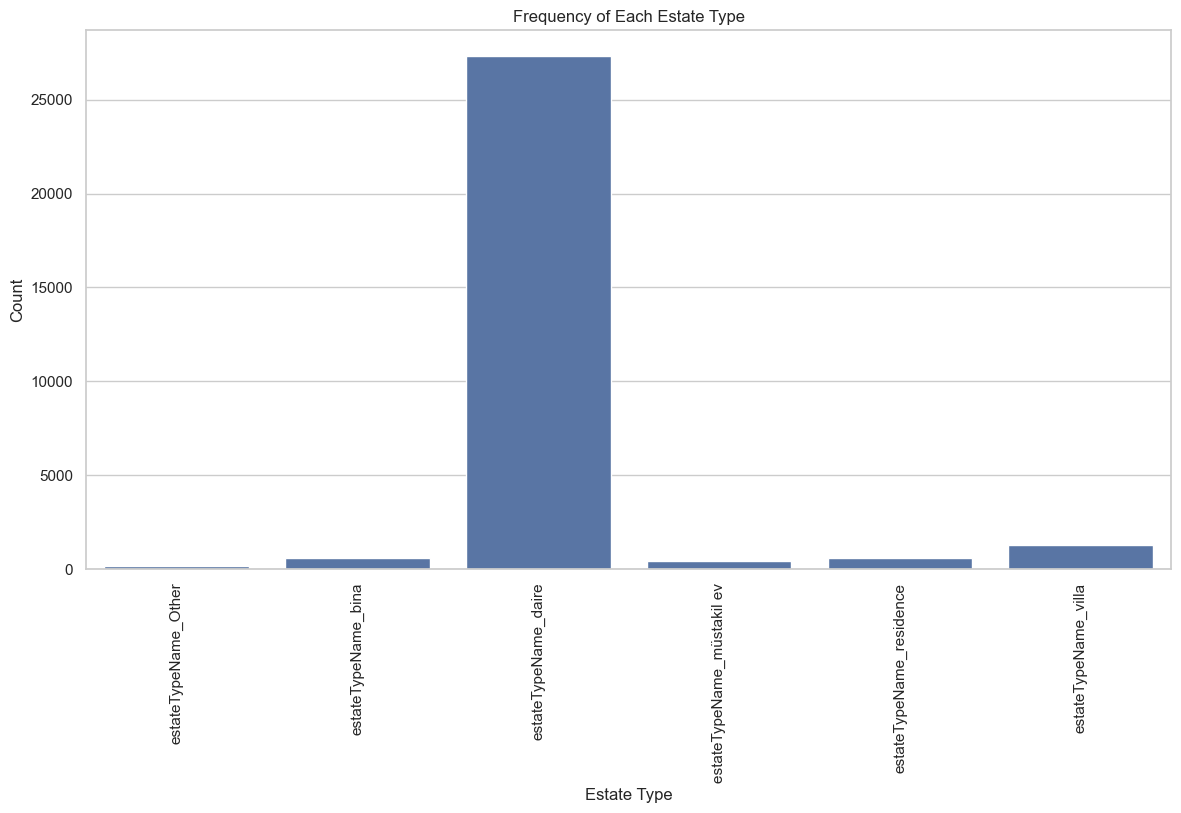

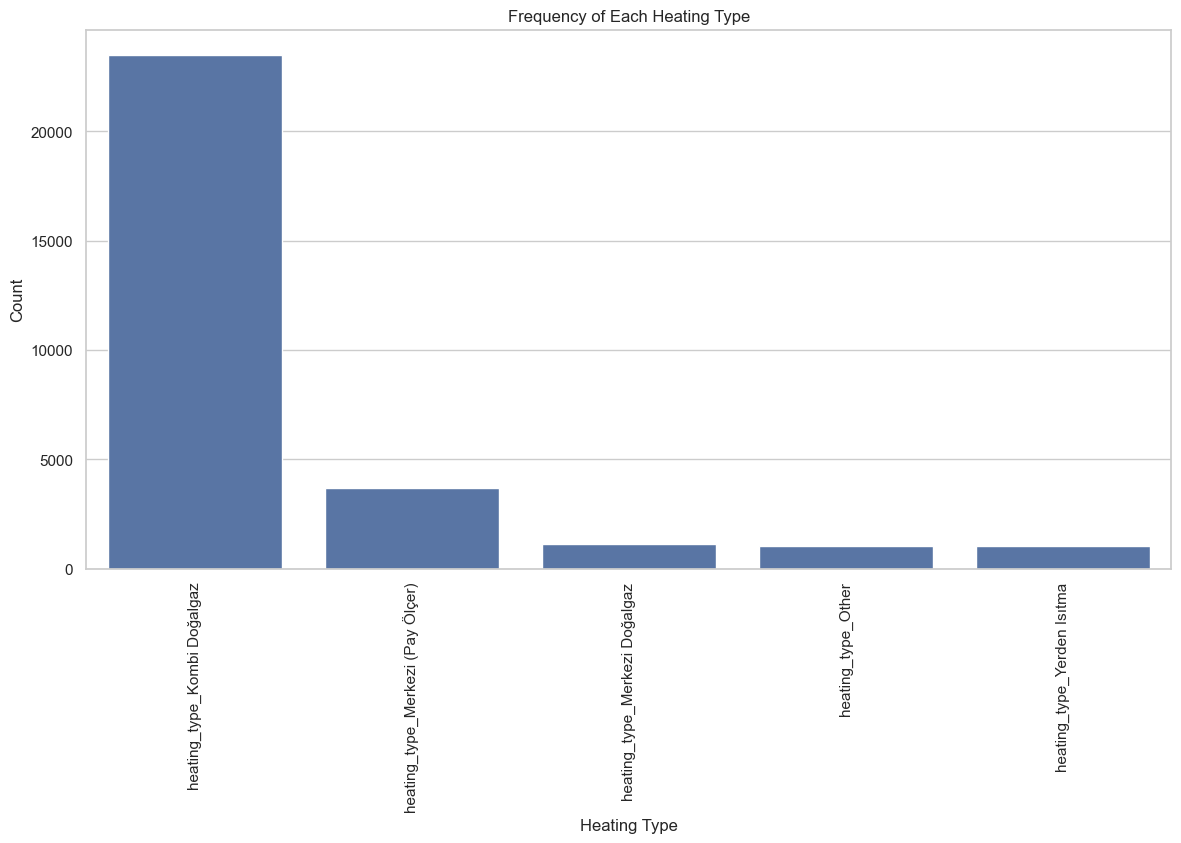

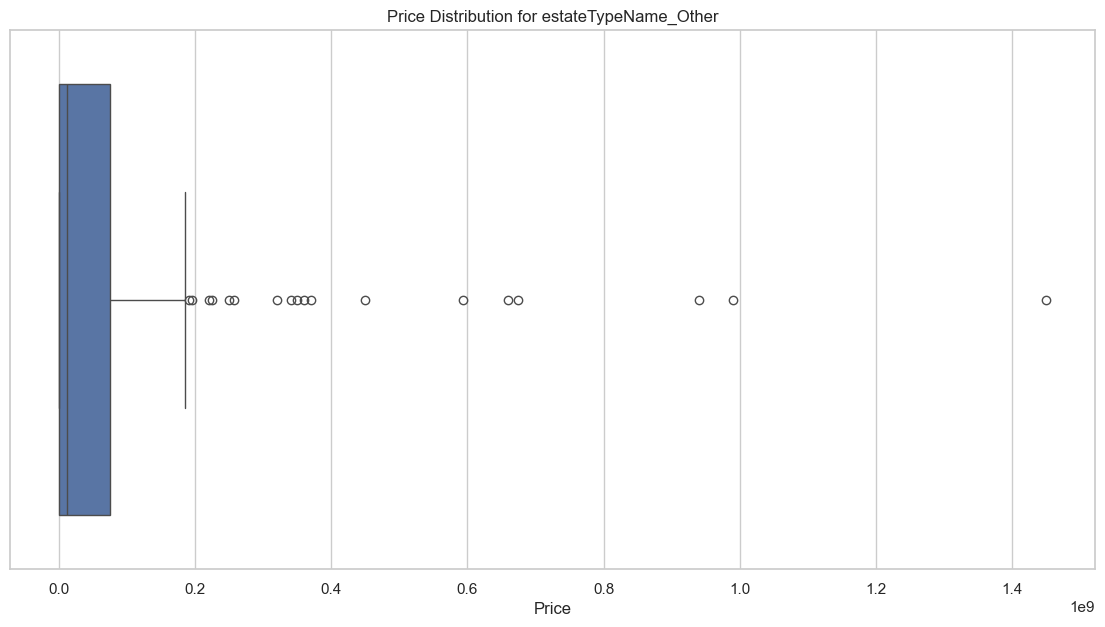

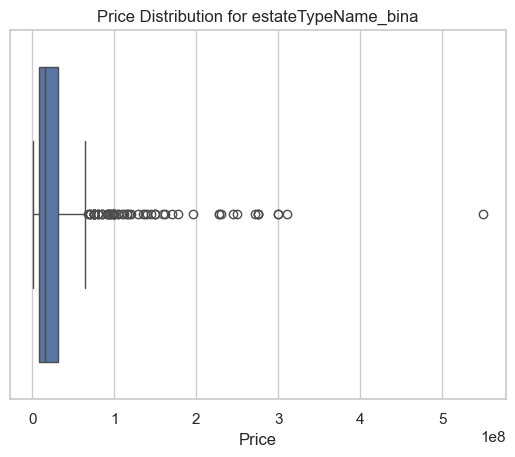

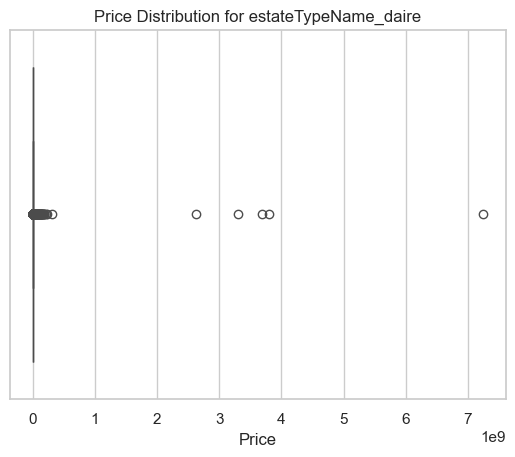

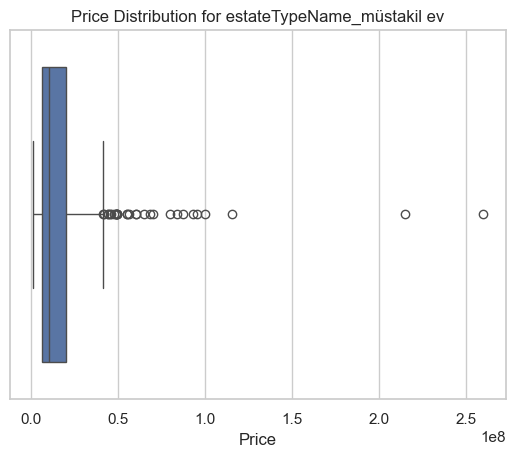

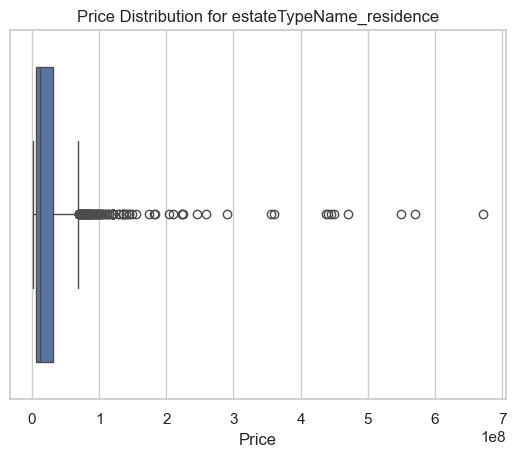

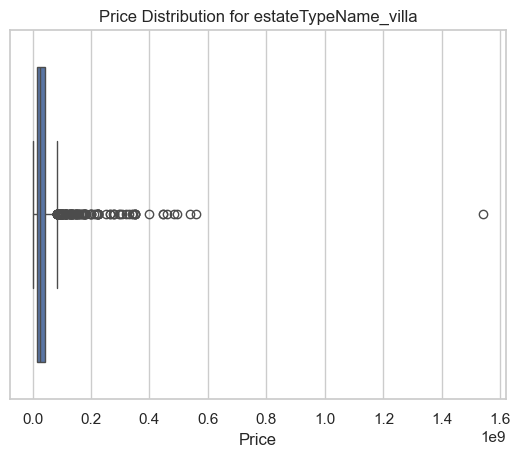

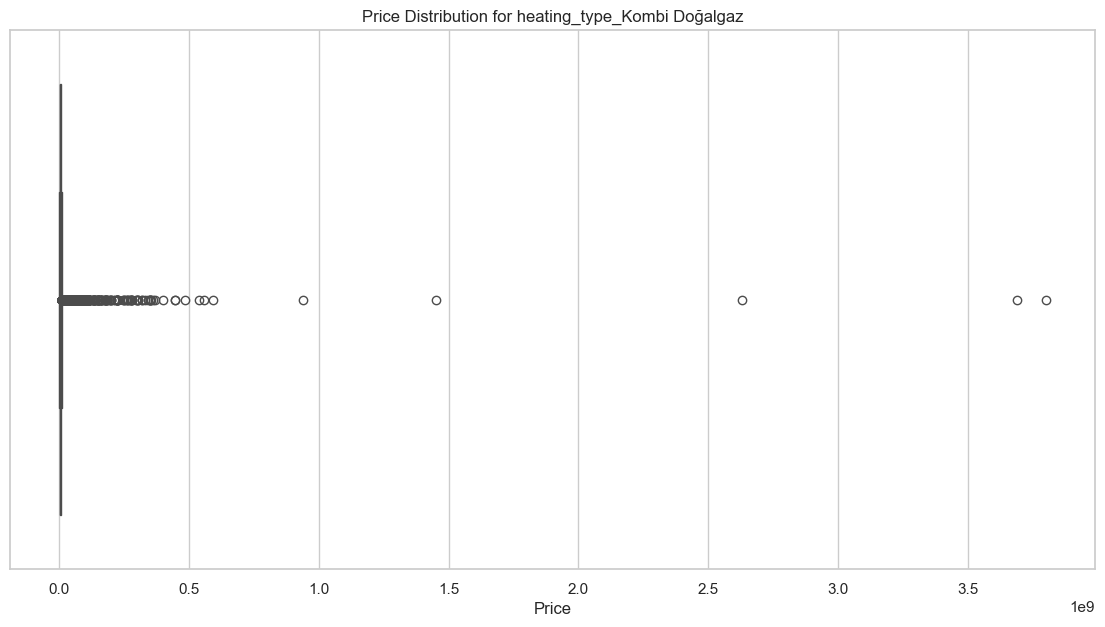

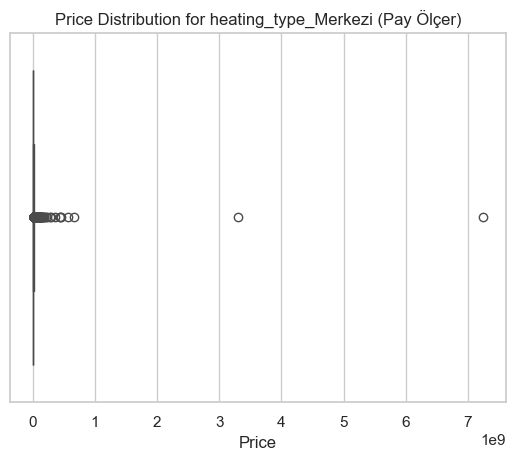

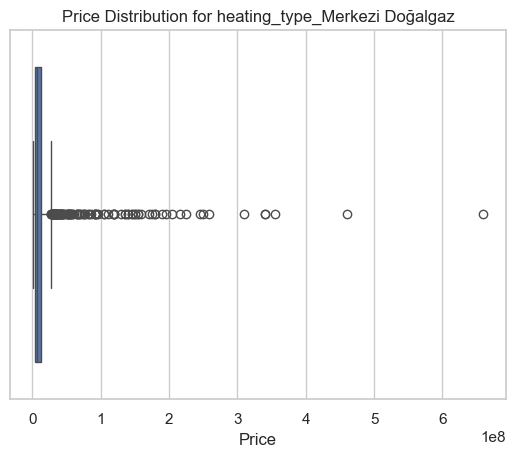

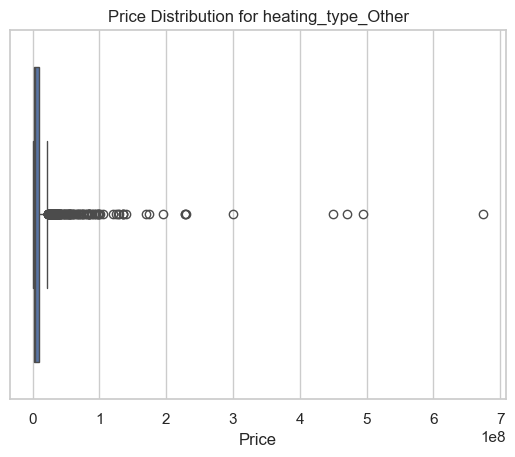

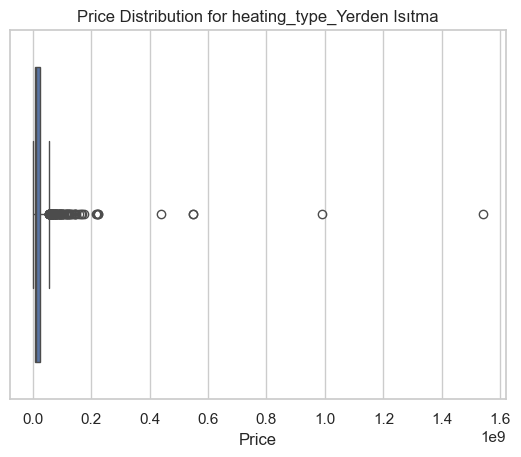

In [43]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Extracting columns for estate types and heating types
estate_type_columns = [col for col in df.columns if 'estateTypeName_' in col]
heating_type_columns = [col for col in df.columns if 'heating_type_' in col]

# Melt the DataFrame for estate types
estate_type_df = df.melt(value_vars=estate_type_columns)
estate_type_df = estate_type_df[estate_type_df['value'] == 1]

# Melt the DataFrame for heating types
heating_type_df = df.melt(value_vars=heating_type_columns)
heating_type_df = heating_type_df[heating_type_df['value'] == 1]

# Plotting bar charts for Estate Types
plt.figure(figsize=(14, 7))
sns.countplot(data=estate_type_df, x='variable')
plt.title('Frequency of Each Estate Type')
plt.xticks(rotation=90)
plt.xlabel('Estate Type')
plt.ylabel('Count')
plt.show()

# Plotting bar charts for Heating Types
plt.figure(figsize=(14, 7))
sns.countplot(data=heating_type_df, x='variable')
plt.title('Frequency of Each Heating Type')
plt.xticks(rotation=90)
plt.xlabel('Heating Type')
plt.ylabel('Count')
plt.show()

if 'price' in df.columns:
    plt.figure(figsize=(14, 7))
    for col in estate_type_columns:
        if df[col].sum() > 0:  
            sns.boxplot(data=df[df[col] == 1], x='price')
            plt.title(f'Price Distribution for {col}')
            plt.xlabel('Price')
            plt.show()

if 'price' in df.columns:
    plt.figure(figsize=(14, 7))
    for col in heating_type_columns:
        if df[col].sum() > 0:  
            sns.boxplot(data=df[df[col] == 1], x='price')
            plt.title(f'Price Distribution for {col}')
            plt.xlabel('Price')
            plt.show()


In [44]:
# Print out numerical features
numerical_features = df.select_dtypes(include='number').columns
print(numerical_features)


Index(['ilanda_kalis_suresi', 'previousPrice', 'price', 'tlPrice',
       'firstPrice', 'differenceRate', 'squareMeterPrice', 'net_square',
       'gross_square', 'room_count', 'build_age', 'floor_number',
       'floor_count', 'district_name_encoded', 'locality_name_encoded',
       'town_name_encoded', 'city.id', 'district.id', 'locality.id', 'town.id',
       'lat', 'lon', 'distance_to_park', 'distance_to_mall', 'rail_distance',
       'lat_rank', 'lon_rank', 'distance_to_sea', 'hospital_distance',
       'hospital_count_2_5km', 'hospital_count_5km', 'hospital_count_1km',
       'hospital_count_10km', 'usd_price', 'moving_estate_index',
       'usd_price/index'],
      dtype='object')


## Exploratory Data Analysis (EDA)

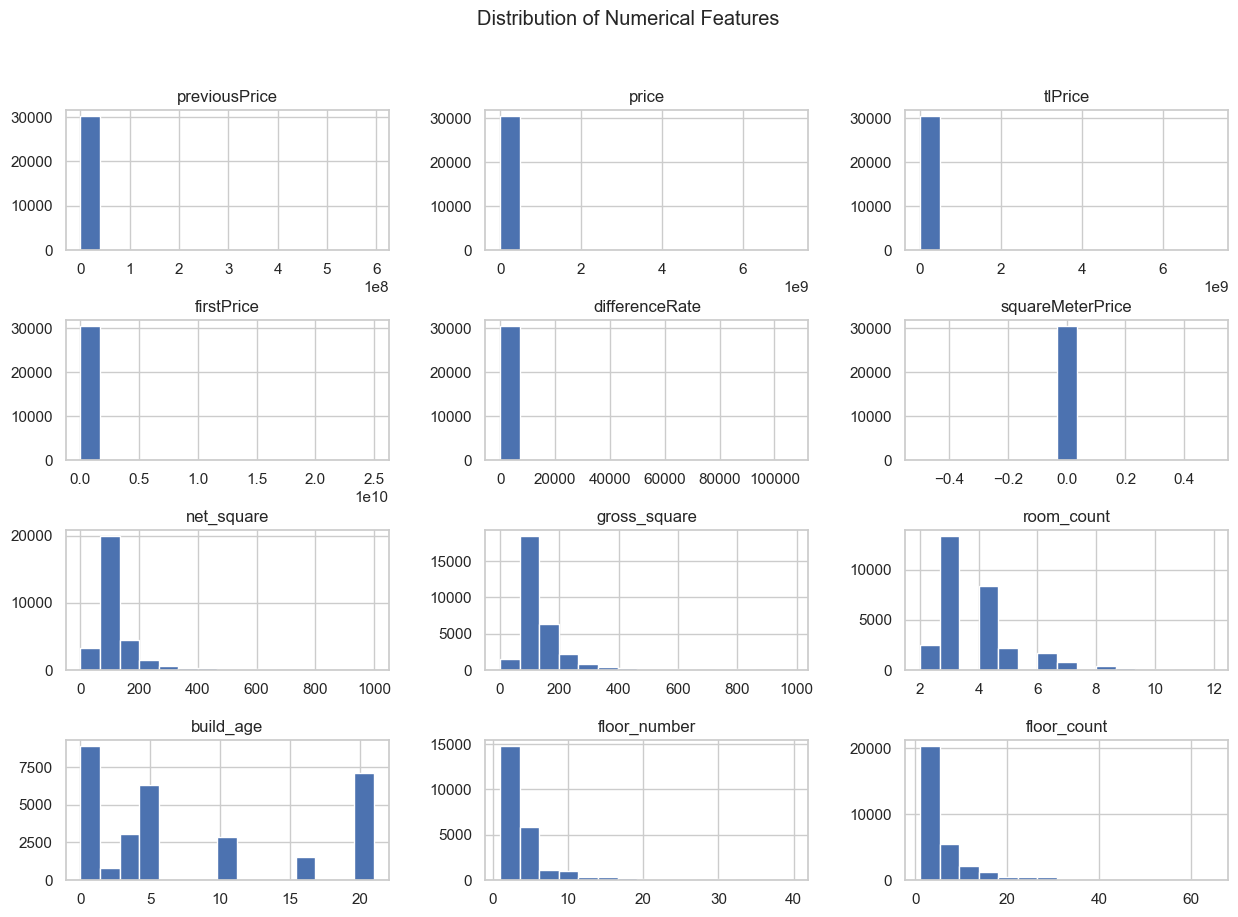

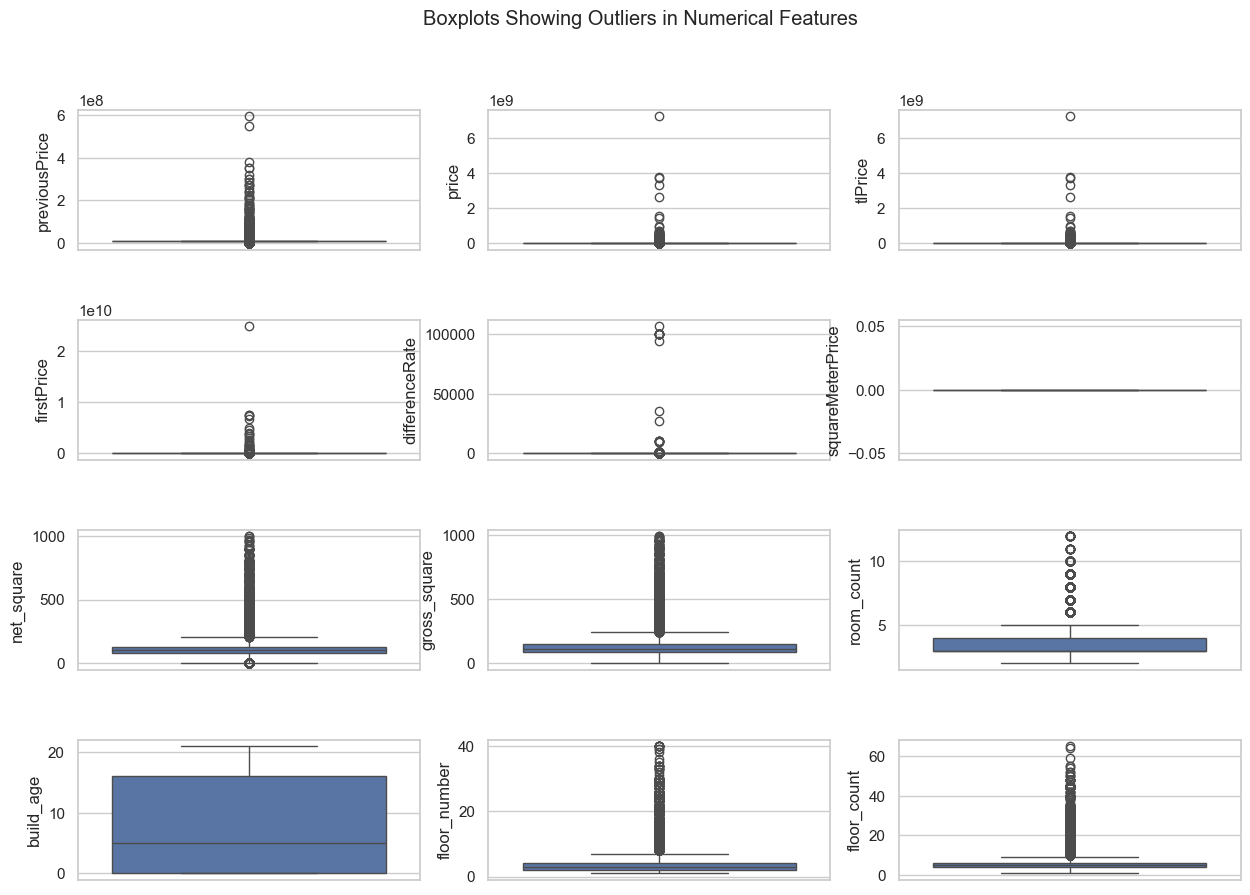

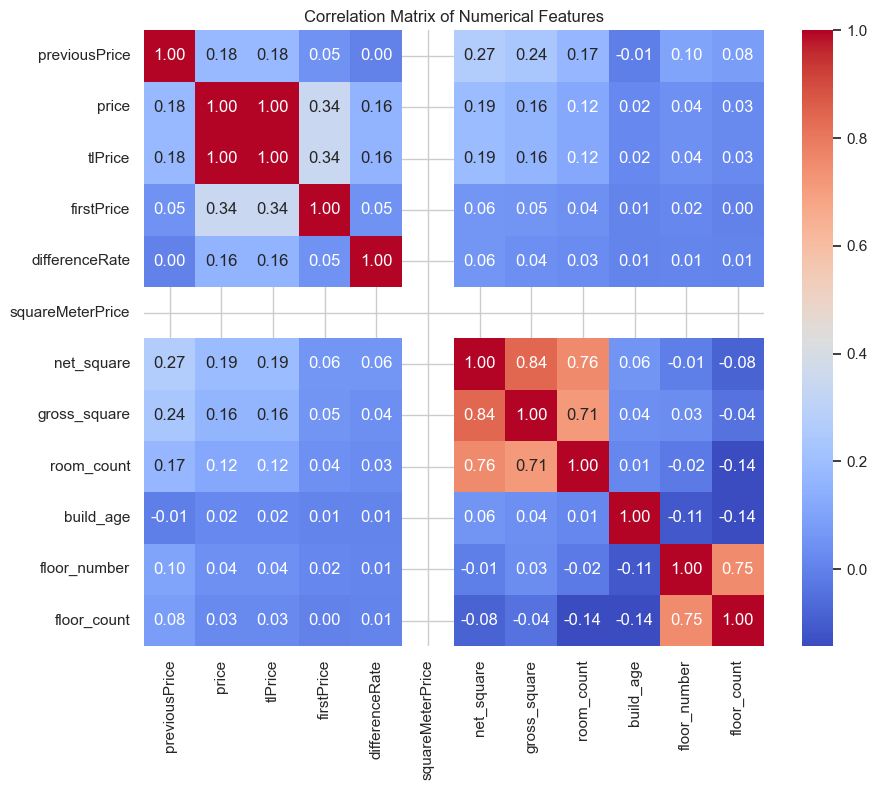

In [45]:
# Histograms for numerical features
numerical_features = ['previousPrice', 'price', 'tlPrice', 'firstPrice', 'differenceRate',
                    'squareMeterPrice', 'net_square', 'gross_square', 'room_count',
                    'build_age', 'floor_number', 'floor_count']

df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(4, 3))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Numerical Features')
plt.show()

# Boxplots for numerical features to spot outliers
fig, ax = plt.subplots(4, 3, figsize=(15, 10))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.boxplot(df[var], ax=subplot)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Boxplots Showing Outliers in Numerical Features')
plt.show()

# Correlation matrix of numerical features
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Step 4: Feature Engineering

## NLTK description keyword analysis

In [46]:
#df


In [47]:
# Adding a few more features
## Description Length
df['description_length'] = df['description'].apply(len)

## Unique Amenities in Description
amenities = ['havuzlu', 'balkon', 'teras', 'asansörlü', 'güvenlik', 'eşyalı']
for amenity in amenities:
    df[f'amenity_{amenity}'] = df['description'].apply(lambda x: 1 if amenity in x.lower() else 0)

## Province Score - to be done

## Listing age days
df['listing_age_days'] = (pd.to_datetime('today') - pd.to_datetime(df['created_at'])).dt.days
df['days_since_update'] = (pd.to_datetime('today') - pd.to_datetime(df['updated_at'])).dt.days

df['is_furnished'] = df['furniture_status'].apply(lambda x: 1 if x == 'Furnished' else 0)
df['is_mortgageable'] = df['mortgage_status'].apply(lambda x: 1 if x == 'Yes' else 0)

df['bath_count'] = pd.to_numeric(df['bath_count'], errors='coerce').fillna(0)
df['balcony_count'] = pd.to_numeric(df['balcony_count'], errors='coerce').fillna(0)

df['credit_suitable'] = df['suitability_for_credit'].apply(lambda x: 1 if x == 'Yes' else 0)
df['investment_suitable'] = df['suitability_for_investor'].apply(lambda x: 1 if x == 'Yes' else 0)

df['image_count'] = df['images'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

In [48]:
# 1. Room to Bathroom Ratio
# Calculate the ratio of rooms to bathrooms
df['room_to_bathroom_ratio'] = df.apply(lambda row: row['room_count'] / row['bath_count'] if row['bath_count'] > 0 else np.nan, axis=1)

# 2. Floor Ratio
# Ratio of floor number to total floor count
df['floor_ratio'] = df.apply(lambda row: row['floor_number'] / row['floor_count'] if row['floor_count'] > 0 else np.nan, axis=1)

# 3. Amenity Score
# Composite amenity score based on selected amenities
df['amenity_score'] = df[['amenity_havuzlu', 'amenity_balkon', 'amenity_güvenlik']].sum(axis=1)

# 4. Age to Floor Ratio
# Ratio of building age to the total number of floors
df['age_to_floor_ratio'] = df.apply(lambda row: row['build_age'] / row['floor_count'] if row['floor_count'] > 0 else np.nan, axis=1)

# 6. Net to Gross Area Ratio
# Calculate net to gross area ratio
df['net_to_gross_ratio'] = df.apply(lambda row: row['net_square'] / row['gross_square'] if row['gross_square'] > 0 else np.nan, axis=1)

# 7. Average Room Size
# Average room size derived from net square footage
df['average_room_size'] = df.apply(lambda row: row['net_square'] / row['room_count'] if row['room_count'] > 0 else np.nan, axis=1)

# 8. Unique Word Count
# Count the unique words in the description
df['unique_word_count'] = df['description'].apply(lambda desc: len(set(desc.split())) if isinstance(desc, str) else 0)

# 9. Positive Adjective Count
# Define a set of positive adjectives for the count, tailored for Turkish real estate listings
positive_adjectives = [
    'lüks', 'şahane', 'geniş', 'yeni','yatırım','yepyeni', 'ulaşımı kolay', 'yatırıma uygun', 'manzaralı', 'bakımlı',
    'güvenlikli', 'asansörlü', 'çift banyolu', 'balkonlu', 'teraslı', 'havuzlu', 'modern', 'rahat', 'konforlu',
    'güzel', 'temiz', 'özel', 'gözde', 'şık', 'kaliteli', 'sıcak', 'huzurlu'
]

# Count the occurrences of positive adjectives in the description
df['positive_adjective_count'] = df['description'].apply(
    lambda desc: sum(1 for word in desc.lower().split() if word in positive_adjectives) if isinstance(desc, str) else 0
)

In [49]:
# Ensure required resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set up Turkish stopwords
turkish_stopwords = stopwords.words('turkish')

# Function to preprocess text: tokenize, remove non-alphabetic words, stopwords
def preprocess_text(text):
    # Tokenize by word
    tokens = word_tokenize(text, language='turkish')
    # Remove non-alphabetic words and stopwords
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in turkish_stopwords]
    return tokens

# Apply preprocessing to each document in the property description column
df['tokens'] = df['description'].fillna('').apply(preprocess_text)

# Flatten the list of tokens and compute frequency distribution
all_tokens = [token for sublist in df['tokens'] for token in sublist]
fdist = FreqDist(all_tokens)

# Get the 25 most common words
most_common_words = fdist.most_common(25)

# Display the most common words and their frequencies
print(most_common_words)


[nltk_data] Downloading package punkt to /Users/melih/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/melih/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('nbsp', 251780), ('yürüme', 16456), ('kat', 11633), ('bir', 10817), ('uygun', 9795), ('daire', 8609), ('yakin', 8327), ('dk', 8147), ('olup', 7637), ('emlak', 7558), ('satilik', 7289), ('detayli', 7197), ('olarak', 6786), ('özel', 6702), ('mutfak', 6463), ('banyo', 6462), ('amp', 6016), ('yaşam', 6009), ('randevu', 5426), ('kapali', 5406), ('lütfen', 5354), ('otopark', 5245), ('konumda', 5192), ('olan', 5187), ('ferah', 5137)]


In [50]:
# List of features to exclude
exclude_features = {'previousValueValid', 'quickInfos', 'suitability_for_investor', 'deed_status', 'square_of_room', 'loan_price', 'created_at', 'subscription_price', 'square_of_balcony', 'balcony_condition', 'parcel_of_land', 'trade', 'opportunity', 'ground_survey', 'category', 'flat_per_floor', 'images', 'tokens', 'square_of_wc', 'balcony_type', 'wc_count', 'suitability_for_credit', 'location', 'tlPrice', 'alternativeValue', 'furniture_status', 'build_type', 'video_navigable', 'trendType', 'previousCurrency', 'currency', 'block_of_buildings', 'trade_type', 'in_site', 'sheet', 'locationSummary', 'tradeTypeName', 'usability', 'updated_at', 'show_unit_price', 'square_of_bath', 'title', 'mortgage_status'}

# Filter out unwanted features
df = df.drop(columns=[col for col in exclude_features if col in df.columns])
# df['price_change_percentage'] = ((df['previousPrice'] - df['firstPrice']) / df['firstPrice']) * 100
# df['price_per_square_meter'] = df['firstPrice'] / df['gross_square']

## Feature Selections, Sentiment Analysis

# Step 5: Training and Testing Data

Training model...
Model: RandomForestRegressor
MSE: 0.01777967513883398
RMSE: 0.13334044824746158
R² score: 0.7831735519487506
Number of features used in the model: 36
Provided feature names count:  36
Feature ranking:
1. feature bath_count (0.2157)
2. feature lon (0.1207)
3. feature gross_square (0.0859)
4. feature net_to_gross_ratio (0.0462)
5. feature lat (0.0459)
6. feature district_name_encoded (0.0431)
7. feature age_to_floor_ratio (0.0424)
8. feature distance_to_sea (0.0412)
9. feature distance_to_mall (0.0396)
10. feature floor_count (0.0275)
11. feature rail_distance (0.0269)
12. feature estateTypeName_bina (0.0189)
13. feature net_square (0.0186)
14. feature distance_to_park (0.0183)
15. feature heating_type_Kombi Doğalgaz (0.0172)
16. feature room_count (0.0169)
17. feature estateTypeName_daire (0.0153)
18. feature locality_name_encoded (0.0148)
19. feature hospital_distance (0.0136)
20. feature average_room_size (0.0134)


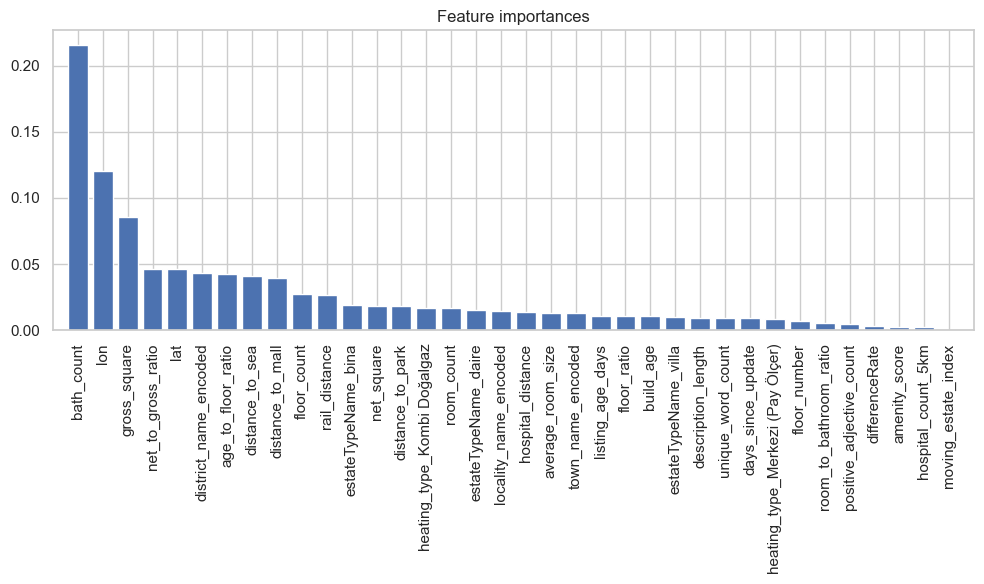

Top 20 Best Valued Listings:
       actual_price  predicted_price  price_difference  percentage_difference
16680      0.049740         0.508792          0.459052             922.909000
30120      0.006715         0.064514          0.057799             860.762963
27387      0.052227         0.444857          0.392630             751.780950
11464      0.049740         0.419793          0.370053             743.980000
9313       0.007461         0.037646          0.030185             404.568889
11823      0.049740         0.233196          0.183456             368.831998
28127      0.154193         0.694919          0.540726             350.681075
7574       0.114302         0.438174          0.323872             283.348563
5119       0.090526         0.333598          0.243072             268.509777
25001      0.208907         0.678258          0.469352             224.670476
7897       0.060185         0.191024          0.130839             217.395036
28858      0.099479         0.31556

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
"""
nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

# Load the sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, framework='pt')

def preprocess_text(text):
    tokens = nltk.word_tokenize(text, language='turkish')
    tokens = [word for word in tokens if word.isalpha() and word.lower() not in turkish_stopwords]
    return ' '.join(tokens)

def batch_sentiment_analysis(texts, batch_size=64):
    results = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_encoded = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**batch_encoded)
        predictions = torch.argmax(outputs.logits, dim=1)
        results.extend(predictions.numpy())
    return results

def extract_features(df):
    df['description_preprocessed'] = df['description'].fillna('').apply(preprocess_text)
    # df['description_sentiment'] = batch_sentiment_analysis(df['description_preprocessed'].tolist())
    keywords = ['kelepir', 'acil', 'yürüme', 'yakin', 'uygun', 'metro', 'ferah']
    for keyword in keywords:
        df[f'keyword_{keyword}'] = df['description_preprocessed'].apply(lambda x: 1 if keyword in x.lower() else 0)
    return df


df = extract_features(df)

# Initialize and apply TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=7, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description_preprocessed'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()


# Check if TF-IDF features are already present in DataFrame
if not set(tfidf_feature_names).issubset(df.columns):
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)
    df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)
"""
# Ensure the features list includes both original and TF-IDF features
filtered_features = [
    'bath_count', 'description_length', 'listing_age_days', 'days_since_update',
    'lat', 'lon', 'distance_to_sea', 'rail_distance', 'room_to_bathroom_ratio', 'floor_ratio', 'amenity_score',
    'age_to_floor_ratio', 'net_to_gross_ratio', 'average_room_size', 'unique_word_count', 'positive_adjective_count',
    'net_square', 'gross_square', 'room_count', 'build_age', 'floor_number', 'floor_count', 'differenceRate',
    'estateTypeName_bina', 'estateTypeName_daire', 'estateTypeName_villa',
    'heating_type_Kombi Doğalgaz', 'heating_type_Merkezi (Pay Ölçer)', 'hospital_distance', 'hospital_count_5km',
    'district_name_encoded', 'locality_name_encoded', 'town_name_encoded', 'distance_to_park', 'distance_to_mall',
    'moving_estate_index'
]  # + list(tfidf_feature_names)


'''
filtered_features = [

            'bath_count', 'balcony_count',
            # 'credit_suitable', 'investment_suitable', 'image_count','is_mortgageable',
            'description_length', 'listing_age_days', 'days_since_update', 'is_furnished',
            'amenity_havuzlu', 'amenity_balkon', 'amenity_teras', 'amenity_asansörlü', 'amenity_güvenlik', 'amenity_eşyalı',
            # 'firstPrice', 'previousPrice',
            # 'squareMeterPrice',
                        'net_square', 'gross_square', 'room_count',
            'build_age', 'floor_number', 'floor_count', 'differenceRate',
            'estateTypeName_Other', 'estateTypeName_bina',
            'estateTypeName_daire', 'estateTypeName_müstakil ev',
            'estateTypeName_residence', 'estateTypeName_villa',
            'heating_type_Kombi Doğalgaz', 'heating_type_Merkezi (Pay Ölçer)',
            'heating_type_Merkezi Doğalgaz', 'heating_type_Other',
            'heating_type_Yerden Isıtma', 'build_status_Other',
            'build_status_Sıfır', 'build_status_İkinci El', 'description_sentiment',
           # 'keyword_kelepir',
            'keyword_acil', 'keyword_yürüme', 'keyword_yakin',
            'keyword_uygun', 'keyword_metro', 'keyword_ferah' ]


filtered_features = [
    'price_change_percentage', 'price_per_square_meter', 'listing_age_days', 'differenceRate',
    'estateTypeName_bina', 'gross_square', 'description_length', 'net_square',
    'days_since_update', 'floor_count', 'room_count', 'floor_number',
     'bath_count', 'build_age', 'estateTypeName_daire'
]  + list(tfidf_feature_names)

'''



# Remove duplicates from the feature list
filtered_features = list(set(filtered_features))

# Filter the DataFrame for outliers
Q1 = df['usd_price/index'].quantile(0.25)
Q3 = df['usd_price/index'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['usd_price/index'] >= lower_bound) & (df['usd_price/index'] <= upper_bound)]

# Recalculate the numerical features from the filtered DataFrame
X_numerical_filtered = df_filtered[filtered_features].fillna(df_filtered[filtered_features].median())

# Scale numerical features
scaler = StandardScaler()
X_numerical_scaled_filtered = scaler.fit_transform(X_numerical_filtered)

X_filtered = X_numerical_scaled_filtered

# Labels
y_filtered = df_filtered['usd_price/index']

all_feature_names = filtered_features
# Check for duplicate features in the final feature list
duplicate_features = [feature for feature in all_feature_names if all_feature_names.count(feature) > 1]
if duplicate_features:
    print(f"Duplicate features found: {duplicate_features}")

# Splitting the data
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

"""
##READY MODEL
# Load the model
import joblib
loaded_model = joblib.load("random_forest_model.joblib")
# Assuming X_new and y_new are your new data and true labels
y_new_pred = loaded_model.predict(X_filtered)
# Calculate and print the evaluation metrics
mse_new = mean_squared_error(y_filtered, y_new_pred)
rmse_new = np.sqrt(mse_new)
r2_new = r2_score(y_filtered, y_new_pred)
print("Evaluation of previous model on New Data:")
print(f"RMSE: {rmse_new}")
print(f"R² score: {r2_new}")
"""

def train_evaluate_model(model, X_train, X_test, y_train, y_test, feature_names):
    print("Training model...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Model: {model.__class__.__name__}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R² score: {r2}')

    # Check if the number of features matches
    print("Number of features used in the model:", X_train.shape[1])
    print("Provided feature names count: ", len(feature_names))

    if len(feature_names) != X_train.shape[1]:
        print("Error: Mismatch in the number of features used for model training and provided feature names.")

        all_features = list(tfidf_feature_names) + [col for col in df.columns if col not in tfidf_feature_names and 'description' not in col]

        # Comparing provided feature names with all possible features derived from data preprocessing
        missing_features = set(all_features) - set(feature_names)
        print("Missing features from provided names:", missing_features)
        extra_features = set(feature_names) - set(all_features)
        print("Extra features in provided names:", extra_features)
    else:
        print("Feature ranking:")
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            for f in range(min(20, len(feature_names))):  # Show top 20 features
                print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

            plt.figure(figsize=(10, 6))
            plt.title("Feature importances")
            plt.bar(range(len(importances)), importances[indices], align='center')
            plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
            plt.xlim([-1, len(importances)])
            plt.tight_layout()
            plt.show()

    # Identify listings where the actual price is less than predicted (good value)
    results_df = pd.DataFrame({
        'actual_price': y_test.tolist(),
        'predicted_price': y_pred,
        'price_difference': y_pred - y_test.tolist(),
        'percentage_difference': ((y_pred - y_test.tolist()) / y_test.tolist()) * 100
    }, index=y_test.index)

    # Filter out extreme outliers where percentage difference is over 1000%
    filtered_good_value_listings = results_df[(results_df['percentage_difference'] > 0) & (results_df['percentage_difference'] < 1000)]

    # Sort by percentage difference to find the top listings
    top_20_value_listings = filtered_good_value_listings.sort_values(by='percentage_difference', ascending=False).head(20)
    print("Top 20 Best Valued Listings:")
    print(top_20_value_listings)
    print("-" * 80)

    # Fetch the URLs for the top 20 listings
    top_20_urls = df_filtered.loc[top_20_value_listings.index, 'url']

    # Extract IDs from URLs
    top_20_ids = top_20_urls.apply(lambda x: x.split('-')[-1].split('.')[0])

    # Print and save the IDs to a JSON file
    print("Top 20 Best Valued Listings IDs:")
    print(top_20_ids)
    top_20_ids.to_json('top_listings_ids.json', orient='records', lines=True)

feature_names = all_feature_names  # This should include all feature names used to form

model = RandomForestRegressor(n_estimators=100, random_state=42)
"""
model.fit(X_filtered, y_filtered)
import joblib
joblib.dump(model, "random_forest_model.joblib")
"""
train_evaluate_model(model, X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered, feature_names)


Model: RandomForestRegressor
MSE: 102234315875.35577
RMSE: 319741.01375231135
R² score: 0.9827651158684666
Number of features used in the model: 30
Provided feature names count:  30

Model: RandomForestRegressor
MSE: 101809835478.13597
RMSE: 319076.53545526654
R² score: 0.9828366757004031
Number of features used in the model: 25
Provided feature names count:  25

Model: RandomForestRegressor
MSE: 99428632295.75981
RMSE: 315323.06020296045
R² score: 0.9832381041306762
Number of features used in the model: 20
Provided feature names count:  20

Model: RandomForestRegressor
MSE: 117408693023.56415
RMSE: 342649.51922272437
R² score: 0.9802069862455676
Number of features used in the model: 52
Provided feature names count:  52


## PCA Analysis for Dimensionality Reduction

In [52]:
"""
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Target Variable
y = y_filtered

# List of models to evaluate
models = [
    RandomForestRegressor(n_estimators=100, random_state=42)
]

# Train and evaluate each model with cross-validation
for model in models:
    # Create a pipeline with StandardScaler, PCA, and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
        ('model', model)
    ])

    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Define scorers
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    # Perform cross-validation for both metrics
    mse_scores = cross_val_score(pipeline, X_filtered, y, cv=kf, scoring=mse_scorer)
    r2_scores = cross_val_score(pipeline, X_filtered, y, cv=kf, scoring=r2_scorer)

    # Calculate RMSE from MSE scores
    rmse_scores = np.sqrt(np.abs(mse_scores))

    # Print results
    print(f'Model: {model.__class__.__name__}')
    print(f'Average MSE: {np.mean(mse_scores)}')
    print(f'Average RMSE: {np.mean(rmse_scores)}')
    print(f'Average R² score: {np.mean(r2_scores)}\n')
"""

"\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.decomposition import PCA\n\n# Target Variable\ny = y_filtered\n\n# List of models to evaluate\nmodels = [\n    RandomForestRegressor(n_estimators=100, random_state=42)\n]\n\n# Train and evaluate each model with cross-validation\nfor model in models:\n    # Create a pipeline with StandardScaler, PCA, and the model\n    pipeline = Pipeline([\n        ('scaler', StandardScaler()),\n        ('pca', PCA(n_components=0.95)),  # Keep 95% of variance\n        ('model', model)\n    ])\n\n    # Cross-validation setup\n    kf = KFold(n_splits=5, shuffle=True, random_state=42)\n\n    # Define scorers\n    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)\n    r2_scorer = make_scorer(r2_score)\n\n    # Perform cross-validation for both metrics\n    mse_scores = cross_val_score(pipeline, X_filtered, y, cv=kf, scoring=mse_scorer)\n    r2_scores = cross_val_score(pipeline, X_fil

## Cross Validation

In [56]:
# Convert X_filtered from sparse to dense if necessary for neural network models
X_dense = X_filtered.toarray() if hasattr(X_filtered, "toarray") else X_filtered

y = y_filtered

def train_evaluate_model_cv(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

    rmse_scores = np.sqrt(np.abs(mse_scores))
    
    print(f'Model: {model.__class__.__name__}')
    print(f'Average MSE: {np.mean(mse_scores)}')
    print(f'Average RMSE: {np.mean(rmse_scores)}')
    print(f'Average R² score: {np.mean(r2_scores)}\n')

X_for_cv = X_dense

# List of models to evaluate
models = [
    # LinearRegression(),
    RandomForestRegressor(n_estimators=100, random_state=42)
]

# Train and evaluate each model with cross-validation
for model in models:
    train_evaluate_model_cv(model, X_for_cv, y)

Model: RandomForestRegressor
Average MSE: -0.018421370568145648
Average RMSE: 0.13570257259540436
Average R² score: 0.786861154183588



## Training on Full Data

In [54]:
import joblib
def train_evaluate_on_full_data(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)  # Train on the entire dataset
    y_pred = model.predict(X)  # Predict on the same dataset
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    print("Training and Testing on Full Dataset:")
    print(f"RMSE: {rmse}")
    print(f"R² score: {r2}")

    #joblib.dump(model, "random_forest_model.joblib")

train_evaluate_on_full_data(X_dense, y)


Training and Testing on Full Dataset:
RMSE: 0.04955048532145747
R² score: 0.9716484293268227


## Ilanda Kalış Süresi Tahmini

In [64]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Filter the DataFrame for passive ads (is_active == False)
df_passive = df[df['is_active'] == False]

# Features and target variable
X = df_passive[['usd_price/index', 'usd_price', 'price', 'bath_count', 'description_length',
                 'lat', 'lon', 'distance_to_sea', 'rail_distance', 
                 'room_to_bathroom_ratio', 'floor_ratio', 'amenity_score', 
                 'age_to_floor_ratio', 'net_to_gross_ratio', 'average_room_size', 
                 'unique_word_count', 'positive_adjective_count', 'net_square', 
                 'gross_square', 'room_count', 'build_age', 'floor_number', 
                 'floor_count', 'differenceRate']]

y = df_passive['ilanda_kalis_suresi']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the sizes of the training and testing sets
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)  # Convert negative MSE to RMSE

# Print cross-validation scores
print(f'Cross-validated RMSE: {cv_rmse}')
print(f'Mean Cross-validated RMSE: {cv_rmse.mean()}')

# Fit the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics for the test set
print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test R² score: {r2}')


Training set size: 2027
Test set size: 507
Cross-validated RMSE: [108.04403393 180.48776159  90.75418413 110.43990015 103.89003769]
Mean Cross-validated RMSE: 118.72318349762142
Test MSE: 9131.32211351684
Test RMSE: 95.557951597535
Test R² score: 0.37291710612461315


## Results Overview

   - Full Data Training and Testing
        RMSE: 155,731
        R² score: 0.996

   - Cross-Validation
        Average RMSE: 420,672
        Average R² score: 0.970

         there is a difference of 264,94 rmse between the full data training and testing and cross-validation results.

         The RMSE increased by about 169.9% when using cross-validation compared to the full data training and testing.
         This indicates that the model may be overfitting to the training data, as the performance on unseen data is significantly worse.

         R² score difference (0.996 vs. 0.970) appear small as R² is often less sensitive to overfitting visually because it is a relative measure of fit.